In [1]:
from pycocotools.coco import COCO

import matplotlib.pyplot as plt
import cv2

import os
import numpy as np
import random

In [114]:
annFile = '/Users/jiangcx/PycharmProjects/poem/2020Aug_posenet/Tensorflow_PersonLab/cocodata/annotations/person_keypoints_val2017.json'
img = '/Users/jiangcx/PycharmProjects/poem/2020Aug_posenet/Tensorflow_PersonLab/cocodata/val2017'
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [115]:
cats = coco.loadCats(4)
print(f'"1" 对应的类别名称: {cats}')

KeyError: 4

In [116]:
# 获取包含person的所有图片
imgIds = coco.getImgIds(catIds=[1])
print(f'包含person的图片共有：{len(imgIds)}张')

包含person的图片共有：2693张


In [215]:
imgId = imgIds[242]
print(imgId)
imgInfo = coco.loadImgs(imgId)[0]
print(f'图像{imgId}的信息如下：\n{imgInfo}')



279278
图像279278的信息如下：
{'license': 2, 'file_name': '000000279278.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000279278.jpg', 'height': 429, 'width': 640, 'date_captured': '2013-11-15 01:07:24', 'flickr_url': 'http://farm7.staticflickr.com/6101/6275412942_f8dc734c3f_z.jpg', 'id': 279278}


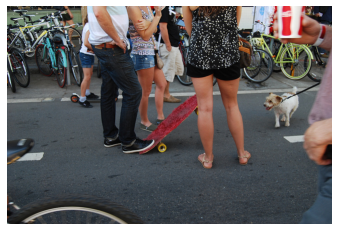

In [216]:
imPath = os.path.join(img, imgInfo['file_name'])                     
im = cv2.imread(imPath)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(im)
plt.show()

279278
图像279278包含7个ann对象，分别是:
[191891, 203403, 208138, 211838, 224954, 1679886, 2167728]


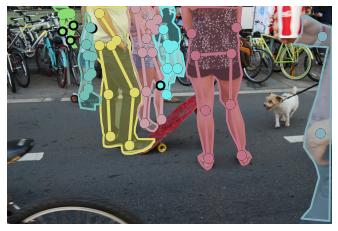

In [217]:
# 获取该图像对应的anns的Id
plt.imshow(im); plt.axis('off')
print(imgInfo['id'])
annIds = coco.getAnnIds(imgIds=imgInfo['id'])
anns = coco.loadAnns(annIds)
print(f'图像{imgInfo["id"]}包含{len(anns)}个ann对象，分别是:\n{annIds}')

coco.showAnns(anns)

In [207]:
mask = coco.annToMask(anns[0])

ann200887对应的mask如下：


(-0.5, 639.5, 426.5, -0.5)

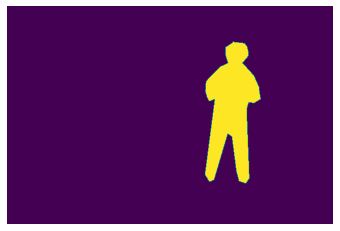

In [206]:
print(f'ann{annIds[0]}对应的mask如下：')
mask = coco.annToMask(anns[0])
plt.imshow(mask); plt.axis('off')

In [146]:
mask.shape

(408, 640)

In [221]:
a = []
a.append(mask)
a.append(mask)
a.append(mask)
a = np.stack(a).transpose((1,2,0))
a.shape

(427, 640, 3)

In [271]:
map_shape = (4,4)

idx = np.rollaxis(np.indices(map_shape[::-1]), 0, 3).transpose((1,0,2))

In [275]:
np.rollaxis(np.indices(map_shape[::-1]), 0, 3)

array([[[0, 0],
        [0, 1],
        [0, 2],
        [0, 3]],

       [[1, 0],
        [1, 1],
        [1, 2],
        [1, 3]],

       [[2, 0],
        [2, 1],
        [2, 2],
        [2, 3]],

       [[3, 0],
        [3, 1],
        [3, 2],
        [3, 3]]])

In [299]:
kp_maps = np.zeros((2,2)+(2,))

In [300]:
c = np.array([[True, False],[False, False]])
kp_maps[c, 1] = 1.

In [325]:
r = 3
x = np.tile(np.arange(r, -r-1, -1), [2*r+1, 1])
y = x.transpose()

In [318]:
m = np.sqrt(x*x + y*y) <= r
np.stack([x, y], axis=-1).shape

(7, 7, 2)

In [310]:
kp_circle = np.stack([x, y], axis=-1) * np.expand_dims(m, axis=-1)

In [332]:
y

array([[ 3,  3,  3,  3,  3,  3,  3],
       [ 2,  2,  2,  2,  2,  2,  2],
       [ 1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1],
       [-2, -2, -2, -2, -2, -2, -2],
       [-3, -3, -3, -3, -3, -3, -3]])

In [334]:
a = np.array([1,2,3,4])
b = np.array([True, False, True,False])
a[b]

array([1, 3])

In [375]:
from scipy.sparse import coo_matrix
def compute_heatmaps(kp_maps, short_offsets):
    # input ke_maps.shape=(h,w,17), short_offsets.shape=(h,w,34)
    heatmaps = []
    map_shape = kp_maps.shape[:2] # (h,w)
    idx = np.rollaxis(np.indices(map_shape[::-1]), 0, 3).transpose((1,0,2)) # create coordination
    for i in range(17):
        this_kp_map = kp_maps[:,:,i:i+1]
        votes = idx + short_offsets[:,:,2*i:2*i+2]
        
        votes = np.reshape(np.concatenate([votes, this_kp_map], axis=-1), (-1, 3))
        print(votes)
        heatmaps.append(accumulate_votes(votes, shape=map_shape) / (np.pi*32**2))
    return np.stack(heatmaps, axis=-1)
def accumulate_votes(votes, shape):
    xs = votes[:,0] # 
    ys = votes[:,1]
    ps = votes[:,2]
    tl = [np.floor(ys).astype('int32'), np.floor(xs).astype('int32')]
    tr = [np.floor(ys).astype('int32'), np.ceil(xs).astype('int32')]
    bl = [np.ceil(ys).astype('int32'), np.floor(xs).astype('int32')]
    br = [np.ceil(ys).astype('int32'), np.ceil(xs).astype('int32')]
    dx = xs - tl[1]
    dy = ys - tl[0]
    tl_vals = ps*(1.-dx)*(1.-dy)
    tr_vals = ps*dx*(1.-dy)
    bl_vals = ps*dy*(1.-dx)
    br_vals = ps*dy*dx
    data = np.concatenate([tl_vals, tr_vals, bl_vals, br_vals])
    I = np.concatenate([tl[0], tr[0], bl[0], br[0]])
    J = np.concatenate([tl[1], tr[1], bl[1], br[1]])
    good_inds = np.logical_and(I >= 0, I < shape[0])
    good_inds = np.logical_and(good_inds, np.logical_and(J >= 0, J < shape[1]))
    heatmap = np.asarray(coo_matrix( (data[good_inds], (I[good_inds],J[good_inds])), shape=shape ).todense())
    return heatmap

In [376]:
kp_maps = np.zeros((401,401,17))
short_offsets = np.ones((401,401,17*2))
compute_heatmaps(kp_maps, short_offsets)

[[  1.   1.   0.]
 [  2.   1.   0.]
 [  3.   1.   0.]
 ...
 [399. 401.   0.]
 [400. 401.   0.]
 [401. 401.   0.]]
[[  1.   1.   0.]
 [  2.   1.   0.]
 [  3.   1.   0.]
 ...
 [399. 401.   0.]
 [400. 401.   0.]
 [401. 401.   0.]]
[[  1.   1.   0.]
 [  2.   1.   0.]
 [  3.   1.   0.]
 ...
 [399. 401.   0.]
 [400. 401.   0.]
 [401. 401.   0.]]
[[  1.   1.   0.]
 [  2.   1.   0.]
 [  3.   1.   0.]
 ...
 [399. 401.   0.]
 [400. 401.   0.]
 [401. 401.   0.]]
[[  1.   1.   0.]
 [  2.   1.   0.]
 [  3.   1.   0.]
 ...
 [399. 401.   0.]
 [400. 401.   0.]
 [401. 401.   0.]]
[[  1.   1.   0.]
 [  2.   1.   0.]
 [  3.   1.   0.]
 ...
 [399. 401.   0.]
 [400. 401.   0.]
 [401. 401.   0.]]
[[  1.   1.   0.]
 [  2.   1.   0.]
 [  3.   1.   0.]
 ...
 [399. 401.   0.]
 [400. 401.   0.]
 [401. 401.   0.]]
[[  1.   1.   0.]
 [  2.   1.   0.]
 [  3.   1.   0.]
 ...
 [399. 401.   0.]
 [400. 401.   0.]
 [401. 401.   0.]]
[[  1.   1.   0.]
 [  2.   1.   0.]
 [  3.   1.   0.]
 ...
 [399. 401.   0.]
 [400. 401.

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [351]:
np.rollaxis(np.indices(map_shape[::-1]), 0, 3)


(4, 1, 2)


In [349]:
cc.transpose((1,0,2)).shape

(1, 4, 2)

In [4]:
import numpy as np
import math
BODY_PARTS_KPT_IDS = [[1, 8], [8, 9], [9, 10], [1, 11], [11, 12], [12, 13], [1, 2], [2, 3], [3, 4], [2, 16],
                      [1, 5], [5, 6], [6, 7], [5, 17], [1, 0], [0, 14], [0, 15], [14, 16], [15, 17]]
print(len(BODY_PARTS_KPT_IDS))
def _set_paf(paf_map, x_a, y_a, x_b, y_b, stride, thickness):
    x_a /= stride
    y_a /= stride
    x_b /= stride
    y_b /= stride
    x_ba = x_b - x_a
    y_ba = y_b - y_a
    _, h_map, w_map = paf_map.shape
    x_min = int(max(min(x_a, x_b) - thickness, 0))
    x_max = int(min(max(x_a, x_b) + thickness, w_map))
    y_min = int(max(min(y_a, y_b) - thickness, 0))
    y_max = int(min(max(y_a, y_b) + thickness, h_map))
    norm_ba = (x_ba * x_ba + y_ba * y_ba) ** 0.5
    if norm_ba < 1e-7:  # Same points, no paf
        return
    x_ba /= norm_ba
    y_ba /= norm_ba

    for y in range(y_min, y_max):
        for x in range(x_min, x_max):
            x_ca = x - x_a
            y_ca = y - y_a
            d = math.fabs(x_ca * y_ba - y_ca * x_ba)
            if d <= thickness:
                paf_map[0, y, x] = x_ba
                paf_map[1, y, x] = y_ba
def _generate_paf_maps(sample):
    n_pafs = len(BODY_PARTS_KPT_IDS)
    n_rows, n_cols, _ = sample['image'].shape
    paf_maps = np.zeros(shape=(n_pafs * 2, n_rows // 8, n_cols // 8), dtype=np.float32)

    label = sample['label']
    
    for paf_idx in range(n_pafs):
        keypoint_a = label['keypoints'][BODY_PARTS_KPT_IDS[paf_idx][0]]
        keypoint_b = label['keypoints'][BODY_PARTS_KPT_IDS[paf_idx][1]]
        if keypoint_a[2] <= 1 and keypoint_b[2] <= 1:
            _set_paf(paf_maps[paf_idx * 2:paf_idx * 2 + 2],
                          keypoint_a[0], keypoint_a[1], keypoint_b[0], keypoint_b[1],
                          8, 1)
        for another_annotation in label['processed_other_annotations']:
            keypoint_a = another_annotation['keypoints'][BODY_PARTS_KPT_IDS[paf_idx][0]]
            keypoint_b = another_annotation['keypoints'][BODY_PARTS_KPT_IDS[paf_idx][1]]
            if keypoint_a[2] <= 1 and keypoint_b[2] <= 1:
                _set_paf(paf_maps[paf_idx * 2:paf_idx * 2 + 2],
                              keypoint_a[0], keypoint_a[1], keypoint_b[0], keypoint_b[1],
                              8, 1)
    return paf_maps

19


In [5]:

import pickle
sample = pickle.load(open('/Users/jiangcx/Documents/sample.pkl','rb'))
print(sample['label'])
#_generate_paf_maps(sample)

{'img_paths': '000000039914.jpg', 'img_width': 368, 'img_height': 368, 'objpos': [171.60053455224408, 176.4390377187478], 'image_id': 39914, 'bbox': [51.54, 210.61, 270.61, 352.21], 'segment_area': 30436.41745, 'scale_provided': 0.9570923913043478, 'num_keypoints': 14, 'segmentations': [], 'keypoints': [[196.27810349422333, 17.54796077365509, 2], [203.90300854979077, 146.550020984258, 1], [215.00195887393116, 150.5718991386705, 1], [226.23315032476938, 156.04982566593662, 1], [241.33624666136174, 153.2822741174327, 1], [192.80405822565035, 142.52814282984548, 1], [170.61432565876123, 140.40401282445225, 1], [152.4655474190045, 132.42570506359652, 1], [193.1257170487878, 186.8776236995756, 1], [174.0279868118945, 211.9085244443296, 1], [157.3433730779651, 235.42066827819727, 1], [177.65453756539068, 180.29265577354073, 1], [158.534991145841, 206.67326398780273, 1], [142.81835363335014, 228.12403830272788, 1], [196.27810349422333, 17.54796077365509, 2], [196.27810349422333, 17.5479607736

In [10]:
def _add_gaussian(keypoint_map, x, y, stride, sigma):
    n_sigma = 4
    tl = [int(x - n_sigma * sigma), int(y - n_sigma * sigma)]    # 根据当前坐标，算出在4sigma内的起点和终点，此处为起点
    tl[0] = max(tl[0], 0)
    tl[1] = max(tl[1], 0)

    br = [int(x + n_sigma * sigma), int(y + n_sigma * sigma)]    #  根据当前坐标，算出在4sigma内的起点和终点，此处为终点
    map_h, map_w = keypoint_map.shape           # 特征图大小
    br[0] = min(br[0], map_w * stride)          # 放大回原始图像大小
    br[1] = min(br[1], map_h * stride)          # 放大回原始图像大小

    shift = stride / 2 - 0.5
    for map_y in range(tl[1] // stride, br[1] // stride):                   # y在特征图上的范围
        for map_x in range(tl[0] // stride, br[0] // stride):               # x在特征图上的范围
            d2 = (map_x * stride + shift - x) * (map_x * stride + shift - x) + \
                (map_y * stride + shift - y) * (map_y * stride + shift - y)
            exponent = d2 / 2 / sigma / sigma
            if exponent > 4.6052:  # threshold, ln(100), ~0.01
                continue
            keypoint_map[map_y, map_x] += math.exp(-exponent)               # 不同关节点热图求和，而非像论文中那样使用max
            if keypoint_map[map_y, map_x] > 1:
                keypoint_map[map_y, map_x] = 1

In [51]:
shift_x = np.arange(0, 50) * 16
shift_y = np.arange(0, 38) * 16
print(shift_y.shape)
shift_x, shift_y = np.meshgrid(shift_x, shift_y)
print(shift_y.shape)
shift_x.ravel().shape

(38,)
(38, 50)


(1900,)

In [73]:
shifts = np.vstack((shift_x.ravel(), shift_y.ravel(),
                            shift_x.ravel(), shift_y.ravel())).transpose()
shifts

array([[  0,   0,   0,   0],
       [ 16,   0,  16,   0],
       [ 32,   0,  32,   0],
       ...,
       [752, 592, 752, 592],
       [768, 592, 768, 592],
       [784, 592, 784, 592]])

In [76]:
anchors = np.array([[ -83.,  -39.,  100.,   56.],
      [-175.,  -87.,  192.,  104.],
      [-359., -183.,  376.,  200.],
      [ -55.,  -55.,   72.,   72.],
      [-119., -119.,  136.,  136.],
      [-247., -247.,  264.,  264.],
      [ -35.,  -79.,   52.,   96.],
      [ -79., -167.,   96.,  184.],
      [-167., -343.,  184.,  360.]])

In [77]:
all_anchors = (anchors.reshape((1, 9, 4)) + shifts.reshape((1, 1900, 4)).transpose((1, 0, 2)))

In [83]:
all_anchors = all_anchors.reshape((1900 * 9, 4))
all_anchors

array([[ -83.,  -39.,  100.,   56.],
       [-175.,  -87.,  192.,  104.],
       [-359., -183.,  376.,  200.],
       ...,
       [ 749.,  513.,  836.,  688.],
       [ 705.,  425.,  880.,  776.],
       [ 617.,  249.,  968.,  952.]])

In [61]:
x.reshape((9,1,4))

array([[[1., 1., 1., 1.]],

       [[1., 1., 1., 1.]],

       [[1., 1., 1., 1.]],

       [[1., 1., 1., 1.]],

       [[1., 1., 1., 1.]],

       [[1., 1., 1., 1.]],

       [[1., 1., 1., 1.]],

       [[1., 1., 1., 1.]],

       [[1., 1., 1., 1.]]])